In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train (1).csv
Saving test.csv to test (1).csv
Saving sample_submission.csv to sample_submission.csv
Saving data_description.txt to data_description.txt


In [ ]:
!pip install pandas scikit-learn xgboost lightgbm

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ..

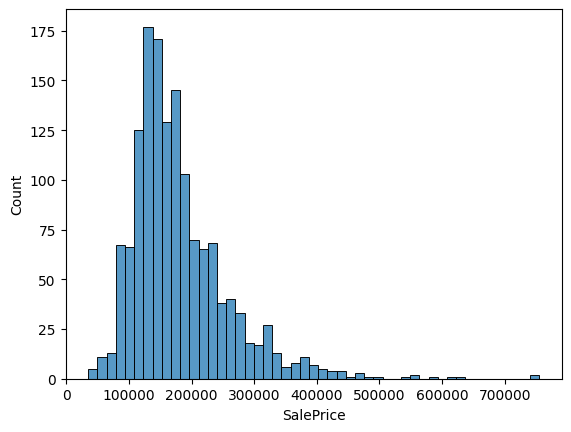

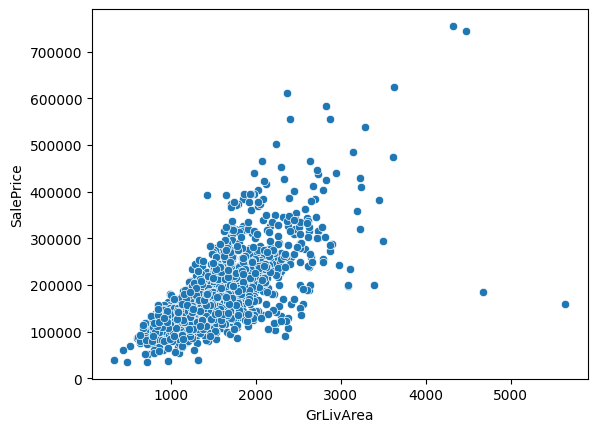

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

In [ ]:

# Load the data
train_df = pd.read_csv("train.csv")

# Explore data distribution
print(train_df.describe())
print(train_df.info())

# Visualize data (examples)
sns.histplot(train_df['SalePrice'])
plt.show()
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_df)
plt.show()

# Correlation analysis (numerical features only)
numerical_cols = train_df.select_dtypes(include=['number']).columns
correlation = train_df[numerical_cols].corr()['SalePrice'].sort_values(ascending=False)
print(correlation)

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

non_numeric_cols = train_df.select_dtypes(exclude=['number']).columns
train_df = pd.get_dummies(train_df, columns=non_numeric_cols, drop_first=True)
test_df = pd.get_dummies(test_df, columns=non_numeric_cols, drop_first=True)

train_cols = set(train_df.columns)
test_cols = set(test_df.columns)
missing_cols = train_cols - test_cols
for col in missing_cols:
    if col != 'SalePrice':
        test_df[col] = 0  # Add missing columns to test data with value 0

# Imputation
numerical_features = train_df.select_dtypes(include=['number']).columns

numerical_features_test = numerical_features.drop(['SalePrice', 'Id'])
for feature in numerical_features:
    train_df[feature].fillna(train_df[feature].mean(), inplace=True)
    if feature in numerical_features_test:
        test_df[feature].fillna(train_df[feature].mean(), inplace=True)

# Feature Scaling
scaler = StandardScaler()
X = train_df.drop(['SalePrice', 'Id'], axis=1)
y = train_df['SalePrice']
X[numerical_features.drop(['SalePrice', 'Id'])] = scaler.fit_transform(X[numerical_features.drop(['SalePrice', 'Id'])])
test_df[numerical_features.drop(['Id', 'SalePrice'])] = scaler.transform(test_df[numerical_features.drop(['Id', 'SalePrice'])]) # Exclude 'SalePrice'

# Now X, y, and test_df are ready for the next step (Applying Algorithms)

<ipython-input-22-303e7d9f5407>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[feature].fillna(train_df[feature].mean(), inplace=True)
<ipython-input-22-303e7d9f5407>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# --- Assumes X, y, and test_df are already defined and preprocessed properly ---

# Step 1: Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Train the XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

# Step 3: Evaluate the model on validation data
xgb_predictions = xgb_model.predict(X_val)
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_predictions))
print("XGBoost RMSE:", xgb_rmse)

# Step 4: Align test_df with training features
X_columns = X.columns
test_features = test_df.drop('Id', axis=1).copy()

# Add any missing columns in test set and fill them with 0
for col in X_columns:
    if col not in test_features.columns:
        test_features[col] = 0

# Drop extra columns not present in training data
extra_cols = set(test_features.columns) - set(X_columns)
if extra_cols:
    test_features.drop(columns=list(extra_cols), inplace=True)

# Ensure column order matches
test_features = test_features[X_columns]

# Step 5: Predict on test set
predictions = xgb_model.predict(test_features)

# Step 6: Create submission file
submission_df = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': predictions})
submission_df.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")


XGBoost RMSE: 25961.083490486293
Submission file saved as 'submission.csv'


In [ ]:
submission_df = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': predictions
})
submission_df.to_csv('submission.csv', index=False)
